# Day 5 - Feature Importance & Model Interpretability
### Machine Learning Roadmap - Week 2 
### Author - N Manish Kumar 
---
In this notebook, we study **why a trained model makes its predictions**.

Goals of the day:
- Understand feature importance in Logistic Regression
- Interpret coefficients and odds ratios
- Visualize which features matter most
- Learn limitations of coefficient-based explanations
---
## 1. Model Interpretability

Model interpretability refers to our ability to understand:
- **Why** a model makes a prediction
- **Which features** influence predictions
- **How strongly** each feature affects the outcome

A highly accurate model is not always a trustworthy model.
Interpretability helps us build models that are:
- Transparent
- Trustworthy
- Debuggable

### Why Interpretability Matters

Interpretability is important because:

- In high-stakes domains (medical, finance), wrong predictions have serious consequences
- Stakeholders need explanations, not just numbers
- It helps detect data leakage and spurious correlations
- It allows us to debug models and improve them
- Regulations often require explainable decisions

### Accuracy vs Explainability

A model can be:
- Very accurate but impossible to explain (black-box)
- Slightly less accurate but fully interpretable (glass-box)

Logistic Regression is a **glass-box model**:
- Every prediction is a weighted sum of features
- Coefficients directly reflect feature influence

This makes Logistic Regression an excellent model
for learning interpretability.

### Global vs Local Interpretability

- **Global interpretability** explains the model as a whole  
  (Which features matter most overall?)

- **Local interpretability** explains a single prediction  
  (Why was this particular sample classified as positive?)

Today, we focus primarily on **global interpretability**
using feature importance.

---
## 2. Logistic Regression Coefficients

In Logistic Regression, each feature has an associated coefficient.

The model is:

$$
f_{w,b}(x) = \sigma(w \cdot x + b)
$$

Where:
- Each coefficient $w_j$ represents the influence of feature $j$
- Positive coefficient → increases probability of class 1
- Negative coefficient → decreases probability of class 1

In this step, we extract and inspect these coefficients.

### Load Final Model & Scaler

In [1]:
import joblib
import pandas as pd
import numpy as np

# Load final regularized model
final_model = joblib.load("../Day4_Regularization/logistic_regression_regularized.pkl")

# Load scaler (for confirmation)
scaler = joblib.load("../Day4_Regularization/scaler.pkl")

### Load Dataset & Feature Names

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
feature_names = data.feature_names

len(feature_names)

30

### Extract Coefficients & Bias


In [4]:
# Coefficeints 
coefficients = final_model.coef_[0]

# Bias
bias = final_model.intercept_[0]

coefficients[:5],bias

(array([-0.51147901, -0.55269775, -0.47629789, -0.54105924, -0.21247927]),
 np.float64(0.3022075735370298))

### Create Coefficient DataFrame

In [5]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficients": coefficients
})

coef_df.head()

,Feature,Coefficients
0,mean radius,-0.511479
1,mean texture,-0.552698
2,mean perimeter,-0.476298
3,mean area,-0.541059
4,mean smoothness,-0.212479


### Interpreting Coefficients

- A **positive coefficient** means the feature increases the probability
  of the positive class (malignant).
- A **negative coefficient** means the feature decreases the probability
  of the positive class.
- The **magnitude** of the coefficient indicates strength of influence,
  but only when features are standardized.

---
## 3. Importance of Feature Standardization

Logistic Regression coefficients represent how much a feature
influences the prediction.

However, coefficient magnitudes are only meaningful when
features are on the **same scale**.

If features are not standardized:
- Large-scale features appear more important
- Small-scale features appear less important
even if the opposite is true.

### Why Scale Matters (Intuition)

Consider two features:
- Feature A ranges from 0 to 1
- Feature B ranges from 0 to 1000

Even if both are equally important,
the model will assign a smaller coefficient to Feature B
to compensate for its larger scale.

Therefore, raw coefficients cannot be compared unless
features are standardized.

### Mathematical View

Logistic Regression computes:

$$
z = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b
$$

If one feature has much larger values,
its coefficient must be smaller to balance the equation.

Standardization ensures:

$$
x_j \sim \mathcal{N}(0, 1)
$$

This allows coefficient magnitudes $|w_j|$ to be compared fairly.

### Confirming Features weree Standardized

In [9]:
# Check mean and std of a few scaled features
X_scaled_sample = scaler.transform(pd.DataFrame(data.data, columns=feature_names))

X_scaled_sample.mean(axis=0)[:5], X_scaled_sample.std(axis=0)[:5]

(array([0.01718724, 0.00960945, 0.01706389, 0.01842323, 0.01434604]),
 array([1.00727175, 0.97654954, 1.00642303, 1.02042997, 1.04529128]))

### Add Absolute Coefficient for Fair Comparison

In [11]:
coef_df.columns

Index(['Feature', 'Coefficients'], dtype='object')

In [12]:
coef_df["Abs_Coefficients"] = coef_df["Coefficients"].abs()

coef_df.head()

,Feature,Coefficients,Abs_Coefficients
0,mean radius,-0.511479,0.511479
1,mean texture,-0.552698,0.552698
2,mean perimeter,-0.476298,0.476298
3,mean area,-0.541059,0.541059
4,mean smoothness,-0.212479,0.212479


### Interpreting Standardized Coefficients

After standardization:
- Larger |coefficient| → stronger feature influence
- Sign (+ / −) → direction of influence
- Absolute value → importance

---
## 4. Visualizing Feature Importance

After standardization, the magnitude of a coefficient indicates
how strongly a feature influences the model.

In this step, we:
- Rank features by absolute coefficient value
- Visualize the most important features
- Distinguish positive and negative influence

### Sort Features by Importance

In [14]:
# Sort features by absolute coefficient value
coef_sorted = coef_df.sort_values(
    by="Abs_Coefficients", ascending=False
)

coef_sorted.head(10)

,Feature,Coefficients,Abs_Coefficients
21,worst texture,-1.255088,1.255088
10,radius error,-1.082965,1.082965
27,worst concave points,-0.953686,0.953686
23,worst area,-0.947756,0.947756
20,worst radius,-0.947616,0.947616
28,worst symmetry,-0.939181,0.939181
13,area error,-0.929104,0.929104
26,worst concavity,-0.823151,0.823151
22,worst perimeter,-0.763220,0.763220
24,worst smoothness,-0.746625,0.746625


### Plot Top 10 Important Features

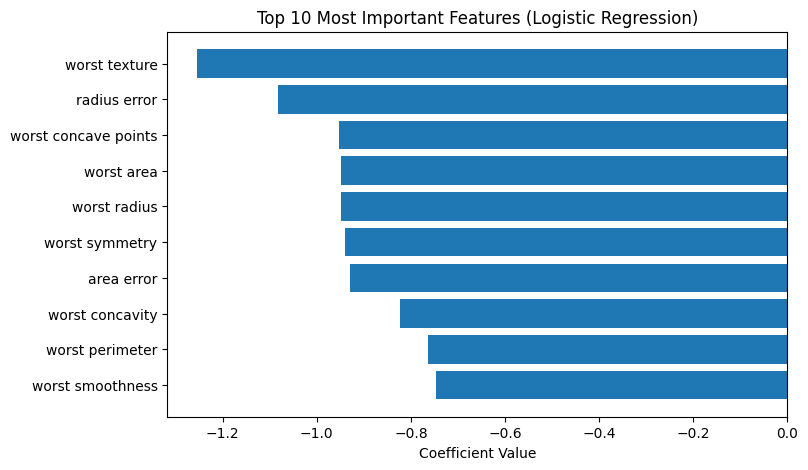

In [16]:
import matplotlib.pyplot as plt

top_n = 10
top_features = coef_sorted.head(top_n)

plt.figure(figsize=(8, 5))
plt.barh(
    top_features["Feature"],
    top_features["Coefficients"]
)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Value")
plt.title("Top 10 Most Important Features (Logistic Regression)")
plt.show()

### Interpretation of Feature Importance

- Features with larger absolute coefficients have a stronger
  influence on the model’s predictions.
- Positive coefficients push predictions toward the malignant class.
- Negative coefficients push predictions toward the benign class.

This ranking represents **global feature importance**.

Feature importance does NOT imply causation.

A feature being important does not mean it causes the outcome.
Correlated features can share importance.

---
## 5. Odds Ratios Interpretation

Logistic Regression models the **log-odds** of the positive class.

The relationship between coefficients and odds is:

$$
\text{odds ratio} = e^{w_j}
$$

Where:
- $w_j$ is the coefficient of feature $j$
- Odds ratio > 1 → increases odds of class 1
- Odds ratio < 1 → decreases odds of class 1

Odds ratios make model behavior easier to explain.

### Compute Odds Ratio

In [18]:
import numpy as np

coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficients"])
coef_df.head()

,Feature,Coefficients,Abs_Coefficients,Odds_Ratio
0,mean radius,-0.511479,0.511479,0.599608
1,mean texture,-0.552698,0.552698,0.575395
2,mean perimeter,-0.476298,0.476298,0.621078
3,mean area,-0.541059,0.541059,0.582131
4,mean smoothness,-0.212479,0.212479,0.808577


### Sort by Odds Ratio

In [20]:
# Strongest increase in odds
coef_df.sort_values("Odds_Ratio",ascending=False).head(5)

,Feature,Coefficients,Abs_Coefficients,Odds_Ratio
5,mean compactness,0.648342,0.648342,1.912367
15,compactness error,0.647227,0.647227,1.910236
19,fractal dimension error,0.437894,0.437894,1.549441
18,symmetry error,0.360492,0.360492,1.434034
11,texture error,0.248823,0.248823,1.282515


In [22]:
# Strongest decrease in odds
coef_df.sort_values("Odds_Ratio",ascending=True).head(5)

,Feature,Coefficients,Abs_Coefficients,Odds_Ratio
21,worst texture,-1.255088,1.255088,0.285051
10,radius error,-1.082965,1.082965,0.338590
27,worst concave points,-0.953686,0.953686,0.385318
23,worst area,-0.947756,0.947756,0.387610
20,worst radius,-0.947616,0.947616,0.387664


### Interpreting Odds Ratios

- Odds Ratio = 1  
  → Feature has no effect

- Odds Ratio > 1  
  → Increases odds of malignant class  
  Example: Odds Ratio = 2 means odds double

- Odds Ratio < 1  
  → Decreases odds of malignant class  
  Example: Odds Ratio = 0.5 means odds are halved

Since features are standardized, a one-unit increase
corresponds to a one standard deviation increase in the feature.

### Example Interpretation

If a feature has:
- Coefficient = 0.7
- Odds Ratio = e^{0.7} ≈ 2.01

Then:
A one standard deviation increase in this feature
approximately doubles the odds of the tumor being malignant.

Odds ratios describe association, not causation.

They indicate how the model uses features,
not why the outcome occurs.

---

## 6. Permutation Feature Importance

Permutation Feature Importance measures how much model performance
decreases when a feature’s values are randomly shuffled.

Idea:
- Shuffle one feature at a time
- Break its relationship with the target
- Measure the drop in performance

Larger drop → more important feature

This method is:
- Model-agnostic
- Based on actual predictions
- Robust to feature scaling

### Compute Permutation Importance

In [28]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load dataset again
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Same split as Day 4 (IMPORTANT)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Recreate scaled test set
X_test_s = scaler.transform(X_test)

In [29]:
from sklearn.metrics import accuracy_score
import numpy as np

# Baseline performance
baseline_pred = final_model.predict(X_test_s)
baseline_acc = accuracy_score(y_test, baseline_pred)

importances = []

# Copy test data to avoid modifying original
X_test_perm = X_test_s.copy()

for i, feature in enumerate(feature_names):
    # Shuffle one feature column
    np.random.shuffle(X_test_perm[:, i])
    
    # Evaluate performance
    perm_pred = final_model.predict(X_test_perm)
    perm_acc = accuracy_score(y_test, perm_pred)
    
    # Importance = drop in performance
    importance = baseline_acc - perm_acc
    importances.append(importance)
    
    # Restore column (important!)
    X_test_perm[:, i] = X_test_s[:, i]

### Create Importance DataFrame

In [30]:
perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Permutation_Importance": importances
})

perm_df_sorted = perm_df.sort_values(
    by="Permutation_Importance", ascending=False
)

perm_df_sorted.head(10)

,Feature,Permutation_Importance
23,worst area,0.035088
21,worst texture,0.035088
10,radius error,0.026316
20,worst radius,0.026316
4,mean smoothness,0.017544
0,mean radius,0.017544
13,area error,0.017544
12,perimeter error,0.017544
24,worst smoothness,0.017544
27,worst concave points,0.017544


###  Visualize Top Permutation Importances


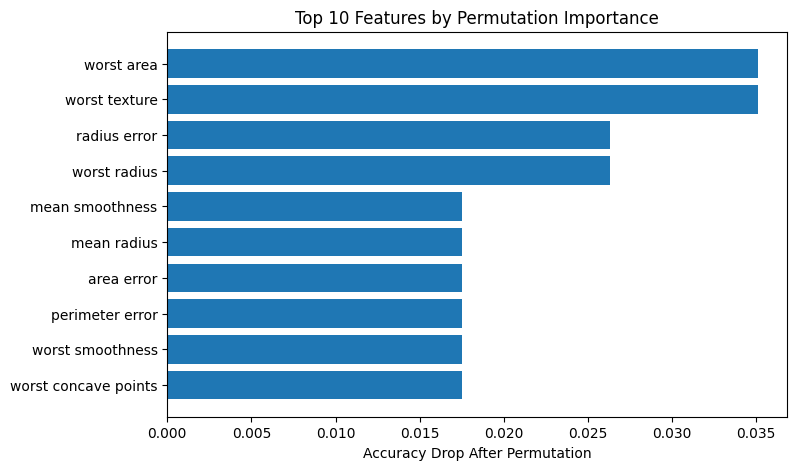

In [31]:
top_n = 10
top_perm = perm_df_sorted.head(top_n)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(
    top_perm["Feature"],
    top_perm["Permutation_Importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Accuracy Drop After Permutation")
plt.title("Top 10 Features by Permutation Importance")
plt.show()

### Interpreting Permutation Importance

- Larger performance drop → more important feature
- Zero or near-zero drop → feature has little impact
- This method reflects how much the model relies on a feature

Permutation importance often confirms but sometimes differs
from coefficient-based importance due to feature correlations.

Permutation importance and coefficient magnitude may differ because:

- Features can be correlated
- Logistic Regression distributes importance across correlated features
- Permutation breaks feature interactions

Therefore, permutation importance often provides a more reliable
measure of real-world feature impact.

Permutation importance and coefficient magnitude may differ because:

- Features can be correlated
- Logistic Regression distributes importance across correlated features
- Permutation breaks feature interactions

Therefore, permutation importance often provides a more reliable
measure of real-world feature impact.

---
## 7. Global vs Local Interpretability

Interpretability can be divided into two categories:
- Global interpretability
- Local interpretability

They answer different questions and are used in different contexts.

### Global Interpretability

Global interpretability explains the model's behavior **as a whole**.

It answers questions like:
- Which features are most important overall?
- How does the model generally make decisions?
- What patterns does the model rely on?

Examples from this notebook:
- Coefficient magnitude analysis
- Odds ratios
- Permutation feature importance

Global explanations describe **average behavior across all data points**.

### Local Interpretability

Local interpretability explains **individual predictions**.

It answers questions like:
- Why was this specific sample classified as malignant?
- Which features influenced this prediction most?

Local explanations focus on **one data point at a time**.

### Interpretability in Logistic Regression

Logistic Regression is inherently interpretable because:
- Predictions are a linear combination of features
- Each feature has a clear coefficient
- Feature effects are additive

This makes it easy to explain:
- Direction of influence
- Relative importance (when standardized)

### Limitations of Logistic Regression Interpretability

Logistic Regression cannot:
- Capture complex feature interactions
- Explain non-linear relationships without feature engineering
- Provide causal explanations

Interpretability shows how the model uses features,
not why the real-world outcome occurs.

### Key Takeaway 

Global interpretability explains model behavior overall.
Local interpretability explains individual predictions.

Both are important, but they answer different questions.

---

## 8. Limitations & Pitfalls of Feature Importance

Although feature importance techniques help explain model behavior,
they must be interpreted with caution. Incorrect interpretation can
lead to false conclusions about the data and the real-world problem.

### Correlated Features
When features are highly correlated:
- Importance may be split across multiple features
- A feature may appear unimportant even if it carries critical information

If two features contain similar information, the model can rely on either,
making individual importance values misleading.

### Multicollinearity
Multicollinearity occurs when multiple features are linearly related.

Effects:
- Coefficients become unstable
- Small changes in data can cause large changes in coefficients
- Feature importance rankings become unreliable

Logistic Regression is especially sensitive to multicollinearity.

### Importance Does Not Mean Causation
Feature importance shows how the model uses a feature,
not whether the feature causes the outcome.

A feature can be important due to:
- Correlation with the target
- Proxy relationships
- Data leakage

Importance reflects association, not causation.

### Data Leakage
If a feature contains information that would not be available
at prediction time, it can dominate importance rankings.

This leads to:
- Artificially high model performance
- Misleading interpretations
- Unrealistic expectations in deployment

### Dataset Dependency
Feature importance depends on:
- The dataset used
- Feature distributions
- The evaluation metric

A feature important in one dataset may be less important in another.

### Key Takeaway
Feature importance explains how a model behaves,
not how the real world works.

Always combine feature importance with domain knowledge,
careful validation, and sound experimental design.

---
# 📝 Day 5 Summary — Feature Importance & Model Interpretability

In this notebook, I explored how to interpret the predictions of a
regularized Logistic Regression model trained on the Breast Cancer dataset.

## Topics Covered
- Meaning of model interpretability and why it matters
- Logistic Regression coefficients and their interpretation
- Importance of feature standardization for fair comparison
- Feature importance using coefficient magnitude
- Odds ratios and their practical interpretation
- Permutation feature importance as a model-agnostic method
- Global vs local interpretability
- Limitations and pitfalls of feature importance

## Key Insights
- Coefficients indicate direction and strength of feature influence
- Odds ratios provide an intuitive multiplicative interpretation
- Permutation importance measures real performance impact
- Correlated features and multicollinearity can distort importance rankings
- Feature importance reflects model behavior, not causation

## Takeaway
Interpretability is essential for building trustworthy machine learning
systems. Feature importance must be combined with domain knowledge
and careful validation to draw meaningful conclusions.

This concludes Week 2 Day 5.